In [1]:
import os
import toml
import wandb
from pycocotools.coco import COCO
import numpy as np
import torch
import torch.nn as nn
import skimage.io as io

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import DataLoader

from src.utils import set_seed
from src.dataloader import COCODataset, Transformations, COCODatasetInference
from src.model import DeepLabV3
from src.train_utils import train_model
from src.losses import dice

In [2]:
DATA_PATH = "/home/glebk/Datasets/dataset_ocr" 
cfg = toml.load("/home/glebk/VSProjects/projects/tmp/src/cfg.toml")


In [4]:
set_seed(cfg["seed"])

In [5]:
t_train = Transformations(
    cfg["img_size"],
    cfg["p_hflip"],
    cfg["p_vflip"],
    cfg["p_invert"],
    cfg["p_rgb_to_gs"],
    cfg["mask_size"],
)
t_test = Transformations(cfg["img_size"], 0, 0, 0, 0, cfg["mask_size"])


In [6]:
annot_file_train = os.path.join(DATA_PATH, "train_tf" + ".json")
coco_train = COCO(annot_file_train)
dataset_train = COCODataset(coco_train, DATA_PATH, t_train)

annot_file_test = os.path.join(DATA_PATH, "test" + ".json")
coco_test = COCO(annot_file_test)
dataset_test = COCODataset(coco_test, DATA_PATH, t_test)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


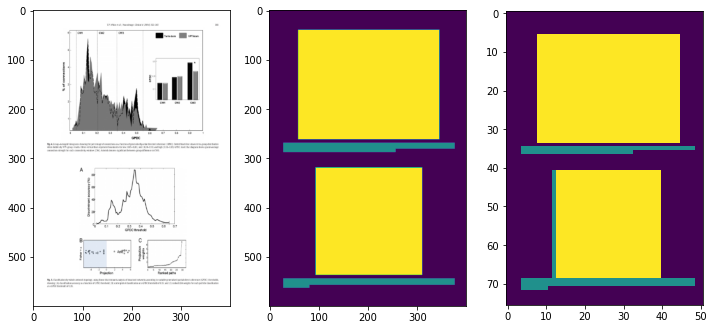

In [7]:
idx = np.random.randint(len(dataset_test))
img, mask, resized_mask = dataset_test[idx]

fig, ax = plt.subplots(1, 3, figsize=(12, 12), sharey=False)
ax[0].imshow(tf.to_pil_image(img))
ax[1].imshow(mask[0])
ax[2].imshow(resized_mask[0])

In [8]:
if cfg["wandb_logging"]:
    wandb.init(project="OCR", entity="glebk")
    wandb.config = cfg


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: glebk (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [9]:
train_loader = DataLoader(dataset_train, batch_size=cfg["bs_train"], shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=cfg["bs_val"], shuffle=False)

print(len(train_loader))
print(len(val_loader))


286
170


In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = DeepLabV3(
    n_classes=cfg["n_classes"],
    n_blocks=cfg["n_blocks"],
    atrous_rates=cfg["atrous_rates"],
    multi_grids=cfg["multi_grids"],
    output_stride=cfg["output_stride"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"])
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, step_size=2500, gamma=0.95, verbose=True
# )

loss = nn.CrossEntropyLoss()

In [11]:
train_model(model, train_loader, val_loader, device, optimizer, scheduler, cfg, loss)


  0%|          | 0/20000 [00:00<?, ?it/s]/home/glebk/VSProjects/venvs/torch_basic/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
loss: 0.01695, avg loss: 0.08218: 100%|██████████| 20000/20000 [3:31:43<00:00,  1.57it/s]


train_loss,0.01695
iter,19999
_runtime,12718
_timestamp,1657035577
_step,20199
val_loss,0.63497


train_loss,▄▃▃▃▃█▂▂▃▂▂▃▂▄▂▂▃▄▄▂▇▂▂▁▃▁▂▂▂▁▂▁▂▁▂▁▁▁▁▁
iter,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▆▆█▇▆▇█▆▇▅▂▆▇▆▃▁█▇▆▇▄▁▄▃▄▂▁▁▁▂▇▁▄▆▇▅▆▆
